In [165]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
df = pd.read_csv('data/AllWaterDataWithHouseHoldIndex.csv')

In [21]:
df.head()

,y,type,household_count
ds,,,
2020-02-26 13:54:26,281.362,NaN,1
2020-02-26 13:58:29,281.362,NaN,1
2020-02-26 14:09:16,281.362,NaN,1
2020-02-26 14:26:31,281.362,NaN,1
2020-02-26 14:28:51,281.362,NaN,1


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48100992 entries, 2020-02-26 13:54:26 to 2021-05-25 09:33:27
Data columns (total 3 columns):
 #   Column           Dtype  
---  ------           -----  
 0   y                float64
 1   type             object 
 2   household_count  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 2.4+ GB


<AxesSubplot:>

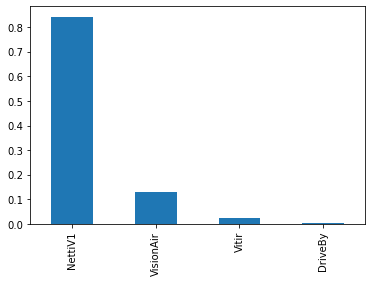

In [26]:
df['type'].value_counts(normalize=True).plot.bar()

In [4]:
household_count = df['household_count'].value_counts(sort='descending')

In [7]:
len(household_count[household_count <= 1])

352

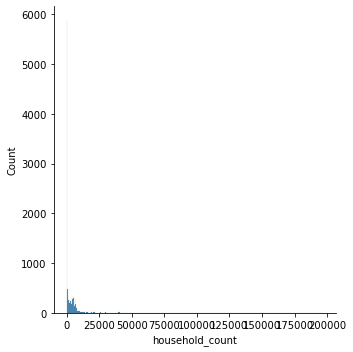

In [9]:
sns.displot(household_count)

In [10]:
df.set_index('ds', inplace=True)

# Filter out only type NettiV1

In [311]:
df_NettiV1 = df[df['type'] == 'NettiV1']
df_NettiV1.head(10)

,y,type,household_count
ds,,,
2020-04-06 13:31:07,293.585,NettiV1,1
2020-04-06 22:22:44,293.750,NettiV1,1
2020-04-06 23:34:49,293.787,NettiV1,1
2020-04-07 00:14:34,293.787,NettiV1,1
2020-04-07 01:24:29,293.789,NettiV1,1
2020-04-07 01:57:38,293.789,NettiV1,1
2020-04-07 02:24:44,293.791,NettiV1,1
2020-04-07 02:50:18,293.791,NettiV1,1
2020-04-07 02:54:39,293.791,NettiV1,1


## NettiV1 preprocessing

### Find duplicated row

In [312]:
df_NettiV1.reset_index(inplace=True)

In [313]:
dups = df_NettiV1.duplicated(keep=False)


In [314]:
len(dups[dups==True])

180725

In [315]:
df_NettiV1[dups]

,ds,y,type,household_count
3150,2021-01-14 02:14:56,382.987,NettiV1,1
3151,2021-01-14 02:14:56,382.987,NettiV1,1
3230,2021-01-14 14:30:35,383.139,NettiV1,1
3231,2021-01-14 14:30:35,383.139,NettiV1,1
3484,2021-01-16 10:31:49,383.813,NettiV1,1
...,...,...,...,...
37738682,2021-03-14 10:11:31,216.280,NettiV1,11347
37738686,2021-03-14 14:21:04,216.333,NettiV1,11347
37738687,2021-03-14 14:21:04,216.333,NettiV1,11347
37739429,2021-04-15 05:54:18,223.722,NettiV1,11347


In [316]:
# Drop duplicates, keep only first apprreance
df_NettiV1.drop_duplicates(keep='first', inplace=True)

C:\Users\taitl\Anaconda3\envs\ds\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


### Filter out data with outliers years

In [317]:
pd.DatetimeIndex(df_NettiV1[df_NettiV1['ds'] < '2020'].ds).year.value_counts()

1980    148
2019      4
1970      1
Name: ds, dtype: int64

In [318]:
df_NettiV1 = df_NettiV1[df_NettiV1['ds'] >= '2020']

### Remove consumption less than 0

In [319]:
df_NettiV1[df_NettiV1['y'] < 0]['household_count'].value_counts()

2472     60
4380     45
1872     38
10123    26
10781    25
881      23
10258    19
8594     19
587      19
8256     18
2283     15
8422     12
1054      8
2951      6
2618      4
6440      3
8301      2
1829      2
9146      2
1782      2
3299      2
Name: household_count, dtype: int64

In [320]:
df_NettiV1 = df_NettiV1[df_NettiV1['y'] > 0]

## Daily resampling for NettiV1 data

In [324]:
df_NettiV1['ds'] = pd.to_datetime(df_NettiV1['ds'])
df_NettiV1.set_index('ds', inplace=True)

In [325]:
df_NettiV1_daily_groupby = df_NettiV1.groupby([pd.Grouper(freq='D'), 'household_count'])

In [326]:
df_NettiV1_daily_groupby['y'].last()

ds          household_count
2020-02-02  10239              427.472
2020-02-17  7113               109.951
2020-02-21  4538               241.889
2020-02-22  10019              114.409
2020-02-23  10019              114.538
                                ...   
2021-05-25  11344              318.935
            11345               33.642
            11346              203.891
            11347              235.187
            11348              142.862
Name: y, Length: 1273632, dtype: float64

In [327]:
# Pivot daily difference into (timestamp, household_count) shape
result = df_NettiV1_daily_groupby['y'].last().unstack('household_count')

In [328]:
result.head(20)

household_count,1,3,5,7,9,10,11,12,15,18,...,11338,11339,11341,11342,11343,11344,11345,11346,11347,11348
ds,,,,,,,,,,,,,,,,,,,,,
2020-02-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [339]:
# Write the result to csv
result.to_csv('data/NettiV1_daily_household_cols.csv')

## Calculate daily difference for each household

In [330]:
daily_diff = result.diff()

In [331]:
daily_diff.head(10)

household_count,1,3,5,7,9,10,11,12,15,18,...,11338,11339,11341,11342,11343,11344,11345,11346,11347,11348
ds,,,,,,,,,,,,,,,,,,,,,
2020-02-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Calculate daily sum for whole area with accepted share of missing values

In [332]:
def return_daily_sum(row, accepted_missing_values_rate):
    daily_sum = 0
    if row.count() < accepted_missing_values_rate*len(row):
        daily_sum = row.sum()
    else:
        daily_sum = np.nan
    return daily_sum

def sum_whole_area(daily_df, accepted_missing_value_per_day=0.7):
    sum_consumption = daily_diff.apply(lambda x: return_daily_sum(x, accepted_missing_value_per_day), axis=1)        
    return sum_consumption

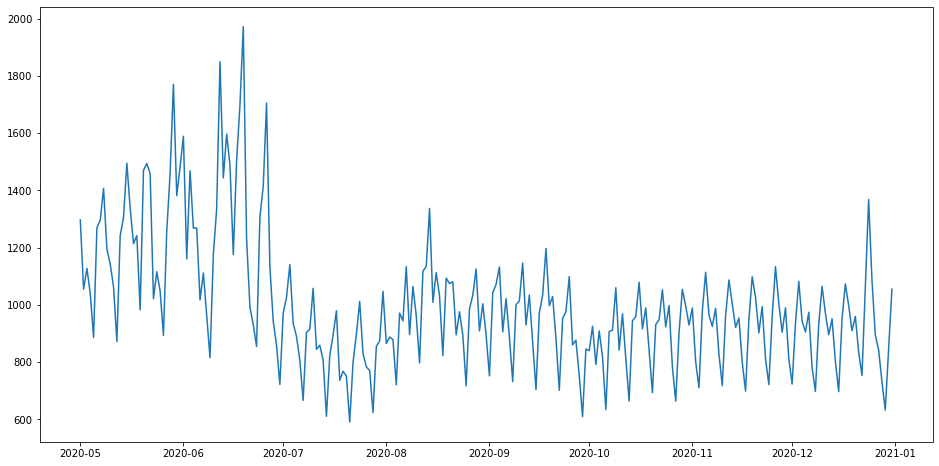

In [333]:
daily_consumption = sum_whole_area(daily_diff, accepted_missing_value_per_day=0.6)
plt.figure(figsize=(16,8))
plt.plot(daily_consumption.loc['2020-05':'2020-12'])

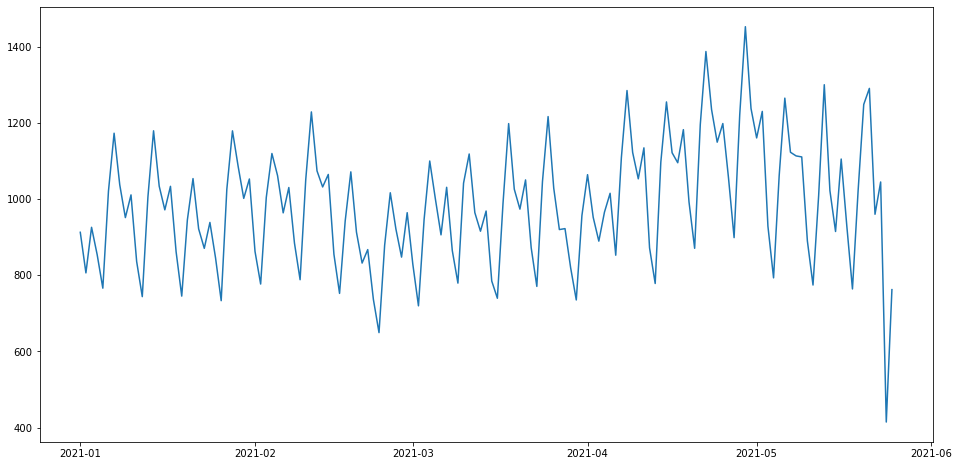

In [350]:
daily_consumption = sum_whole_area(daily_diff, accepted_missing_value_per_day=0.6)
plt.figure(figsize=(16,8))
plt.plot(daily_consumption['2021'])

# Predict with Prophet

In [354]:
df_prophet = pd.DataFrame(daily_consumption['2020-05':'2021-04'])


In [355]:
df_prophet.reset_index(inplace=True)
df_prophet.columns=['ds', 'y']
df_prophet.head()

,ds,y
0,2020-05-01,1296.750
1,2020-05-02,1054.682
2,2020-05-03,1127.538
3,2020-05-04,1039.527
4,2020-05-05,886.040


In [358]:
import prophet as Prophet

In [377]:
m = Prophet.Prophet(weekly_seasonality=True, yearly_seasonality=True)
m.add_country_holidays(country_name='NO')
m.fit(df_prophet)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [378]:
m.train_holiday_names

0                    Søndag
1           Første påskedag
2              Grunnlovsdag
3           Første pinsedag
4         Første nyttårsdag
5           Arbeidernes dag
6            Første juledag
7             Andre juledag
8              Skjærtorsdag
9                Langfredag
10           Andre påskedag
11    Kristi himmelfartsdag
12           Andre pinsedag
dtype: object

In [374]:
# Forcasting into the future
future = m.make_future_dataframe(periods=730)
forecast = m.predict(future)

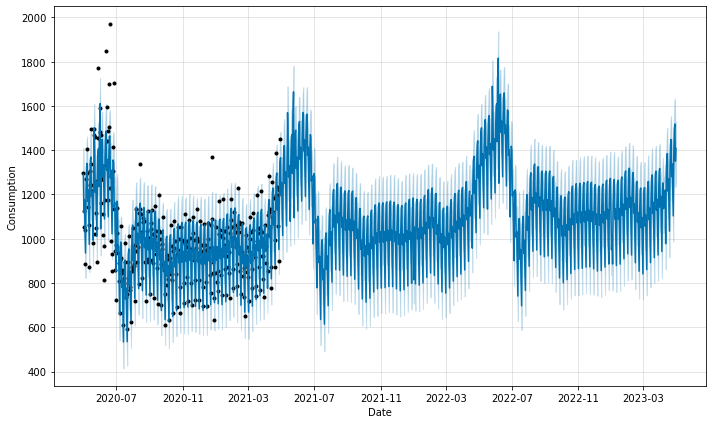

In [375]:
figure = m.plot(forecast, xlabel='Date', ylabel='Consumption')

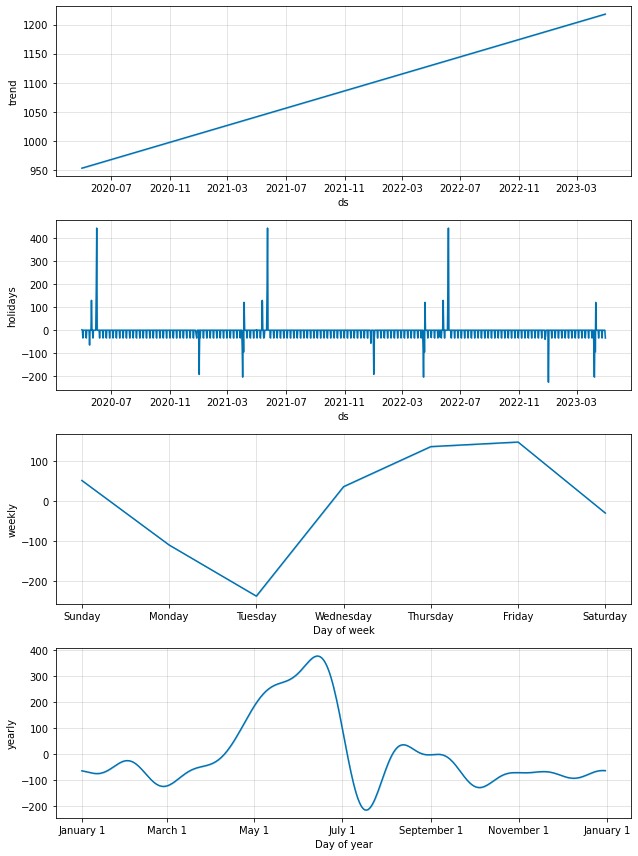

In [376]:
figure = m.plot_components(forecast)